In [1]:
# Colab setup

# try:
#     from dlroms import *
# except:
#     !pip install git+https://github.com/NicolaRFranco/dlroms.git
#     from dlroms import *

In [1]:
import numpy as np
import torch
import os
import time
import random
import gmsh
import matplotlib.pyplot as plt

from dlroms import *

from IPython.display import clear_output as clc

In [ ]:
# Setup

gmsh.initialize()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Domain definition

loop = lambda v: np.concatenate((v, v[[0]]))
brain = np.load(os.path.join('brain_meshes', 'brainshape.npz'))
domain = fe.polygon(loop(brain['main'][::9])) - fe.polygon(loop(brain['hole1'][::9])) - fe.polygon(loop(brain['hole2'][::8]))

# Mesh and function space definition

mesh_H = fe.loadmesh(os.path.join('brain_meshes', 'brain-mesh40.xml'))
Vh_H = fe.space(mesh_H, 'CG', 1)
h_H, nh_H = mesh_H.hmax(), Vh_H.dim()

mesh_C = fe.loadmesh(os.path.join('brain_meshes', 'brain-mesh15.xml'))
Vh_C = fe.space(mesh_C, 'CG', 1)
h_C, nh_C = mesh_C.hmax(), Vh_C.dim()

clc()

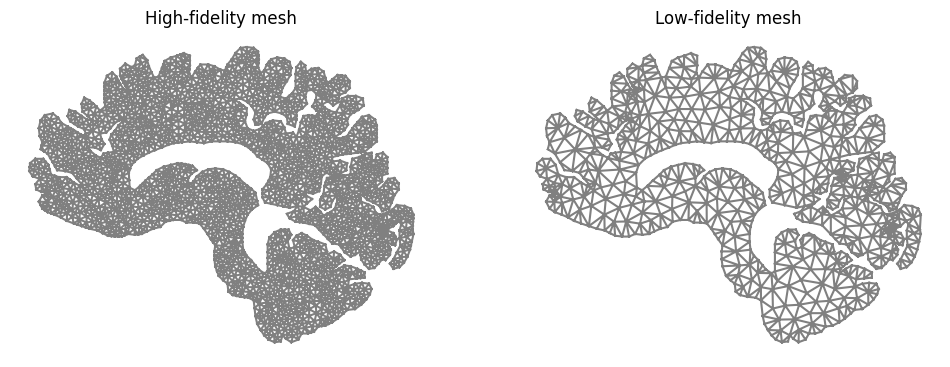

In [4]:
# Plot meshes

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
fe.plot(mesh_H)
plt.title("High-fidelity mesh")
plt.subplot(1, 2, 2)
fe.plot(mesh_C)
plt.title("Low-fidelity mesh")
plt.show()

In [5]:
# Load snapshots

path_train = os.path.join('snapshots', 'snapshots_train.npz')
if not os.path.exists(path_train):
	print(f"Training snapshots not found at {path_train}.")

data_train = np.load(path_train)
N_train = data_train['mu'].shape[0]
mu_train, u_train = data_train['mu'].astype(np.float32), data_train['u'].astype(np.float32)
mu_train, u_train = torch.tensor(mu_train).to(device), torch.tensor(u_train).to(device)

path_test = os.path.join('snapshots', 'snapshots_test.npz')
if not os.path.exists(path_test):
	print(f"Test snapshots not found at {path_test}.")

data_test = np.load(path_test)
N_test = data_test['mu'].shape[0]
mu_test, u_test = data_test['mu'].astype(np.float32), data_test['u'].astype(np.float32)
mu_test, u_test = torch.tensor(mu_test).to(device), torch.tensor(u_test).to(device)

In [7]:
# Mesh-informed network training

layer_1 = Geodesic(domain, Vh_H, Vh_C, support=0.05)
layer_2 = Geodesic(domain, Vh_C, Vh_C, support=0.1)
layer_3 = Geodesic(domain, Vh_C, Vh_H, support=0.05, activation=None)

l2 = L2(Vh_H)
clc()

model = DFNN(layer_1, layer_2, layer_3)
model.He()

if device.type == 'cuda':
	model.cuda()
	l2.cuda()

model.train(mu_train, u_train, ntrain=N_train, epochs=400, loss=mse(l2), verbose=True)

In [ ]:
# Mesh-informed network evaluation

with torch.no_grad():
	u_pred_train = model(mu_train)
	u_pred = model(mu_test)

error_train = mre(l2)(u_train, u_pred_train)
error_test = mre(l2)(u_test, u_pred)
print(f"Relative training error: {100 * torch.mean(error_train):.2f}%")
print(f"Relative test error: {100 * torch.mean(error_test):.2f}%")

In [ ]:
# Plot a random snapshot

idx = 45

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.title("Brain damage")
fe.plot(1 + 0 * mu_test[idx], Vh_H, cmap='jet', vmin=0, vmax=1)
fe.plot(mu_test[idx], Vh_H, cmap='jet', colorbar=True)
plt.subplot(1, 3, 2)
plt.title("True time to recovery")
fe.plot(u_test[idx], Vh_H, cmap='jet', vmin=0, vmax=1, colorbar=True)
plt.subplot(1, 3, 3)
plt.title("Predicted time to recovery")
fe.plot(u_pred[idx], Vh_H, cmap='jet', vmin=0, vmax=1, colorbar=True)
plt.tight_layout()
plt.show()

In [30]:
# Save model

checkpoint_dir = 'checkpoints'
if not os.path.exists(checkpoint_dir):
	os.makedirs(checkpoint_dir)

torch.save(model.state_dict(), os.path.join(checkpoint_dir, 'model.pth'))